In [1]:
import pandas as pd

df = pd.read_csv("drives.csv")

off_counts = df['offense_idx'].value_counts()
def_counts = df['defense_idx'].value_counts()
valid_off_teams = off_counts[off_counts >= 25].index
valid_def_teams = def_counts[def_counts >= 25].index

df_cleaned = df[df['offense_idx'].isin(valid_off_teams) & df['defense_idx'].isin(valid_def_teams)].copy()
print("Total drives after filtering teams with >= 25 drives:", len(df_cleaned))


Total drives after filtering teams with >= 25 drives: 61593


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge

features = ['start_period', 'score_diff_start', 'is_home_offense', 'distance_to_goal', 'goal_to_go']
offense_target = 'points_scored_offense'

offense_encoded = pd.get_dummies(df_cleaned['offense_idx'].astype(str), prefix='offense')

df_train = df_cleaned[df_cleaned['week'] > 8].copy()
df_test = df_cleaned[df_cleaned['week'] < 9].copy()

offense_encoded_train = pd.get_dummies(df_train['offense_idx'].astype(str), prefix='offense').reset_index(drop=True)
offense_encoded_test = pd.get_dummies(df_test['offense_idx'].astype(str), prefix='offense').reset_index(drop=True)

X_train_off = pd.concat([offense_encoded_train, df_train[features].reset_index(drop=True)], axis=1)
X_test_off = pd.concat([offense_encoded_test, df_test[features].reset_index(drop=True)], axis=1)
X_test_off = X_test_off.reindex(columns=X_train_off.columns, fill_value=0)

y_train_off = df_train[offense_target].reset_index(drop=True)
y_test_off = df_test[offense_target].reset_index(drop=True)

ridge_off = Ridge(alpha=1.0)
ridge_off.fit(X_train_off, y_train_off)
n_offense = offense_encoded_train.shape[1]
offense_coeff_train = pd.Series(ridge_off.coef_[:n_offense], index=offense_encoded_train.columns)

ridge_off_test = Ridge(alpha=1.0)
ridge_off_test.fit(X_test_off, y_test_off)
offense_coeff_test = pd.Series(ridge_off_test.coef_[:n_offense], index=offense_encoded_train.columns)

team_name_map_off = df_cleaned[['offense_idx', 'offense']].drop_duplicates().set_index('offense_idx')['offense'].astype(str).to_dict()

offense_coeff_df = pd.DataFrame({
    'team_id': [c.split('_')[-1] for c in offense_coeff_train.index],
    'team_name': [team_name_map_off.get(int(c.split('_')[-1]), 'Unknown') for c in offense_coeff_train.index],
    'train_offense_coeff': offense_coeff_train.values,
    'test_offense_coeff': offense_coeff_test.values
})

print("Offense Coefficients:")
print(offense_coeff_df)

Offense Coefficients:
    team_id          team_name  train_offense_coeff  test_offense_coeff
0         0  Abilene Christian            -1.404316            1.225439
1         1          Air Force             0.102565            0.772421
2        10           Arkansas             0.173125            0.850639
3       100           Marshall            -0.377400            0.290257
4       101           Maryland            -0.317568            1.004227
..      ...                ...                  ...                 ...
147      93            Liberty             0.856596            0.801205
148      96          Louisiana             0.333232            1.010441
149      97     Louisiana Tech            -0.385356            0.446113
150      98         Louisville             0.129175            0.973367
151      99              Maine            -0.471667           -0.437600

[152 rows x 4 columns]


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge

features = ['start_period', 'score_diff_start', 'is_home_offense', 'distance_to_goal', 'goal_to_go']
defense_target = 'points_scored_defense'

df_train_def = df_cleaned[df_cleaned['week'] > 8].copy()
df_test_def  = df_cleaned[df_cleaned['week'] < 9].copy()

defense_encoded_train = pd.get_dummies(df_train_def['defense_idx'].astype(str), prefix='defense').reset_index(drop=True)
defense_encoded_test  = pd.get_dummies(df_test_def['defense_idx'].astype(str), prefix='defense').reset_index(drop=True)

X_train_def = pd.concat([defense_encoded_train, df_train_def[features].reset_index(drop=True)], axis=1)
X_test_def  = pd.concat([defense_encoded_test, df_test_def[features].reset_index(drop=True)], axis=1)
X_test_def  = X_test_def.reindex(columns=X_train_def.columns, fill_value=0)

y_train_def = df_train_def[defense_target].reset_index(drop=True)
y_test_def  = df_test_def[defense_target].reset_index(drop=True)

ridge_def = Ridge(alpha=1.0)
ridge_def.fit(X_train_def, y_train_def)
n_defense = defense_encoded_train.shape[1]
defense_coeff_train = pd.Series(ridge_def.coef_[:n_defense], index=defense_encoded_train.columns)

ridge_def_test = Ridge(alpha=1.0)
ridge_def_test.fit(X_test_def, y_test_def)
defense_coeff_test = pd.Series(ridge_def_test.coef_[:n_defense], index=defense_encoded_train.columns)

team_name_map_def = df_cleaned[['defense_idx', 'defense']].drop_duplicates().set_index('defense_idx')['defense'].astype(str).to_dict()

defense_coeff_df = pd.DataFrame({
    'team_id': [col.split('_')[-1] for col in defense_coeff_train.index],
    'team_name': [team_name_map_def.get(int(col.split('_')[-1]), 'Unknown') for col in defense_coeff_train.index],
    'train_defense_coeff': defense_coeff_train.values,
    'test_defense_coeff': defense_coeff_test.values
})

print("Defense Coefficients:")
print(defense_coeff_df)

Defense Coefficients:
    team_id          team_name  train_defense_coeff  test_defense_coeff
0         0  Abilene Christian             0.460197            0.108645
1         1          Air Force            -0.134000            0.007080
2        10           Arkansas            -0.049394           -0.051932
3       100           Marshall            -0.004391           -0.022257
4       101           Maryland            -0.101139           -0.171819
..      ...                ...                  ...                 ...
147      93            Liberty            -0.066185           -0.093961
148      96          Louisiana            -0.036990            0.058711
149      97     Louisiana Tech            -0.034129           -0.022613
150      98         Louisville             0.006567           -0.094929
151      99              Maine            -0.076491           -0.010602

[152 rows x 4 columns]


In [4]:
team_ratings = pd.merge(offense_coeff_df, defense_coeff_df, on=['team_id', 'team_name'], how='outer')
print(team_ratings.head(10))
team_coeff_clean = team_ratings.dropna()
team_coeff_clean.to_csv("team_coefficients.csv", index=False)

  team_id          team_name  train_offense_coeff  test_offense_coeff  \
0       0  Abilene Christian            -1.404316            1.225439   
1       1          Air Force             0.102565            0.772421   
2      10           Arkansas             0.173125            0.850639   
3     100           Marshall            -0.377400            0.290257   
4     101           Maryland            -0.317568            1.004227   
5     102      Massachusetts            -0.083466            0.108840   
6     104            Memphis             0.883660            1.008933   
7     105             Mercer            -1.046936           -0.040287   
8     106          Merrimack            -0.652267           -0.282702   
9     107              Miami             0.180820            1.471473   

   train_defense_coeff  test_defense_coeff  
0             0.460197            0.108645  
1            -0.134000            0.007080  
2            -0.049394           -0.051932  
3            -0.

In [5]:
import pandas as pd
import numpy as np

df_train = df_cleaned[df_cleaned['week'] < 9].copy()
df_test  = df_cleaned[df_cleaned['week'] > 8].copy()

ppd_train = df_train.groupby('offense_idx')['points_scored_offense'].mean()
ppd_test = df_test.groupby('offense_idx')['points_scored_offense'].mean()

off_coef_corr = np.corrcoef(offense_coeff_train, offense_coeff_test)[0, 1]
print("Correlation between offensive coefficients (train vs test):", round(off_coef_corr, 3))

ppd_train_def = df_train.groupby('defense_idx')['points_scored_defense'].mean()
ppd_test_def  = df_test.groupby('defense_idx')['points_scored_defense'].mean()

def_coef_corr = np.corrcoef(defense_coeff_train, defense_coeff_test)[0, 1]
print("Correlation between defensive coefficients (train vs test):", round(def_coef_corr, 3))

Correlation between offensive coefficients (train vs test): 0.669
Correlation between defensive coefficients (train vs test): 0.004


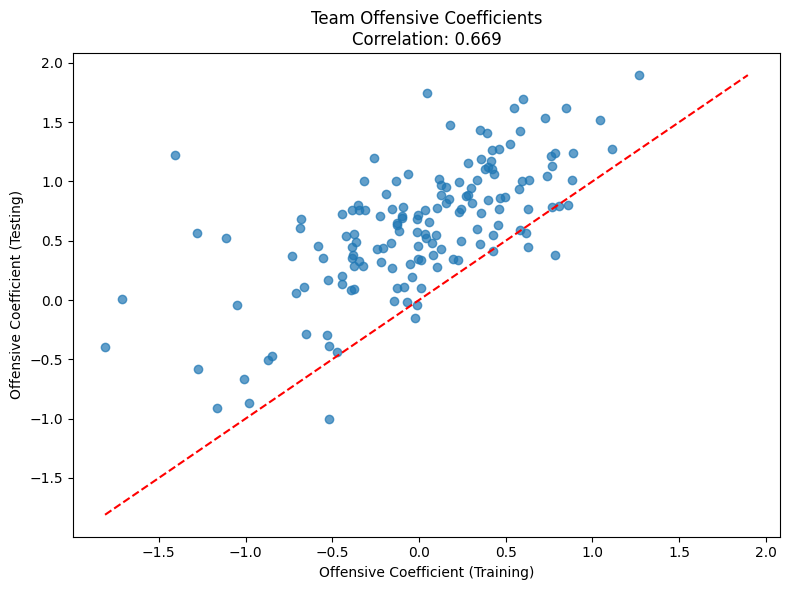

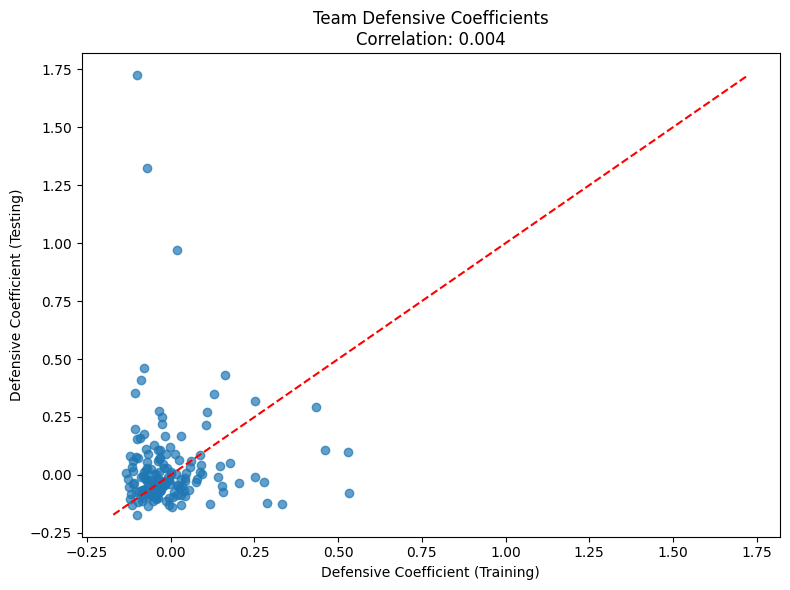

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.scatter(offense_coeff_train, offense_coeff_test, alpha=0.7)
plt.xlabel('Offensive Coefficient (Training)')
plt.ylabel('Offensive Coefficient (Testing)')
plt.title(f"Team Offensive Coefficients\nCorrelation: {off_coef_corr:.3f}")

min_coef = min(offense_coeff_train.min(), offense_coeff_test.min())
max_coef = max(offense_coeff_train.max(), offense_coeff_test.max())
plt.plot([min_coef, max_coef], [min_coef, max_coef], 'r--')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(defense_coeff_train, defense_coeff_test, alpha=0.7)
plt.xlabel('Defensive Coefficient (Training)')
plt.ylabel('Defensive Coefficient (Testing)')
plt.title(f"Team Defensive Coefficients\nCorrelation: {def_coef_corr:.3f}")

min_coef = min(defense_coeff_train.min(), defense_coeff_test.min())
max_coef = max(defense_coeff_train.max(), defense_coeff_test.max())
plt.plot([min_coef, max_coef], [min_coef, max_coef], 'r--')

plt.tight_layout()
plt.show()